**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Visualize the data](#toc1_2_)    
  - [Prepare data](#toc1_3_)    
    - [Files operations](#toc1_3_1_)    
    - [Data operations](#toc1_3_2_)    
    - [Train / test / validation split](#toc1_3_3_)    
    - [Dataloaders](#toc1_3_4_)    
  - [Model](#toc1_4_)    
- [Instances](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [214]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from tqdm import tqdm
import torchtext
import torchtext.data
import re

torch.cuda.is_available()

True

In [215]:
from torchnlp.encoders.text import StaticTokenizerEncoder
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import os

In [216]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <a id='toc1_2_'></a>[Visualize the data](#toc0_)

In [217]:
import matplotlib.pyplot as plt

def plot_history(train_acc_history, train_loss_history, val_acc_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)
    
    # Loss
    plt.figure(1)
    plt.plot(epochs, train_loss_history, 'b', label='Training loss (' + str(format(train_loss_history[-1], '.5f')) + ')')
    plt.plot(epochs, val_loss_history, 'g', label='Validation loss (' + str(format(val_loss_history[-1], '.5f')) + ')')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy
    plt.figure(2)
    plt.plot(epochs, train_acc_history, 'b', label='Training accuracy (' + str(format(train_acc_history[-1], '.5f')) + ')')
    plt.plot(epochs, val_acc_history, 'g', label='Validation accuracy (' + str(format(val_acc_history[-1], '.5f')) + ')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## <a id='toc1_3_'></a>[Prepare data](#toc0_)

### <a id='toc1_3_1_'></a>[Files operations](#toc0_)

In [218]:
def read_glove_file(path: str) -> dict[str, np.ndarray]:
    embeddings: dict = {}
    f = open(path, encoding ="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings))

    return embeddings

In [219]:
def read_imdb() -> tuple[list[str], list[int]]:
    imdb_dir = 'kaggle/Imdb/'
    train_dir = imdb_dir + 'train/'

    labels = []
    texts = []

    for label_type in ['neg', 'pos']:
        dir_name = train_dir + label_type
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname), encoding ="utf8")
                texts.append(f.read())
                f.close()
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)

    return texts, labels

In [220]:
embeddings = read_glove_file('kaggle/glove.twitter.27B/glove.twitter.27B.50d.txt')
texts, labels = read_imdb()

Found 1193514 word vectors.


### <a id='toc1_3_2_'></a>[Data operations](#toc0_)

In [221]:
def texts_to_sequences(texts: list[str], maxlen: int, max_words: int) -> tuple[torch.Tensor, dict[any, int]]:
    tokenizer = StaticTokenizerEncoder(texts, tokenize=lambda s: re.findall(r'([a-zA-Z0-9]+|[\.,;\/\\\'])', s), min_occurrences=1)
    
    sequences = [tokenizer.encode(text) for text in texts]
    word_index = tokenizer.vocab
    word_index_dict = {word: index for index, word in enumerate(word_index)}
    index_word = {index: word for word, index in word_index_dict.items()}
    
    sequences = [[word for word in seq if index_word[word.item()] in embeddings] for seq in sequences]
    
    data = torch.zeros((len(sequences), maxlen), dtype=torch.long)
    
    for i, seq in enumerate(sequences):
        for j, word in enumerate(seq):            
            if j >= maxlen:
                break
            if word < max_words:
                data[i, j] = word
            else:
                data[i, j] = 0

    print([index_word[word.item()] for word in data[0] if word != 0])
                
    return data, word_index_dict

In [222]:
def get_embedding_matrix(max_words: int, embedding_index: dict[str, np.ndarray], word_index: dict[any, int]) -> np.ndarray:
    embedding_dimension = embedding_index.get('the').shape[0]

    embedding_matrix = np.zeros((max_words, embedding_dimension))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                # Words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [223]:
def split_data(data: np.ndarray, labels: list[int], train_part: float, validation_part: float) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    labels = np.asarray(labels)

    data_size = data.shape[0]
    train_size = int(data_size * train_part)
    validation_size = int(data_size * validation_part)
    test_size = data_size - train_size - validation_size

    indices = np.arange(data_size)
    np.random.shuffle(indices)

    train_indices = indices[:train_size]
    validation_indices = indices[train_size:train_size + validation_size]
    test_indices = indices[train_size + validation_size:]

    train_data = data[train_indices]
    validation_data = data[validation_indices]
    test_data = data[test_indices]

    train_labels = labels[train_indices]
    validation_labels = labels[validation_indices]
    test_labels = labels[test_indices]

    print(f"Train data size: {train_data.shape[0]}")
    print(f"Validation data size: {validation_data.shape[0]}")
    print(f"Test data size: {test_data.shape[0]}")

    return train_data, validation_data, test_data, train_labels, validation_labels, test_labels

### <a id='toc1_3_3_'></a>[Train / test / validation split](#toc0_)

In [224]:
def prepare_data_for_model(maxlen: int, max_words: int, embeddings: dict[str, np.ndarray], texts: list[str], labels: list[int], train_part: float, validation_part: float) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, dict[any, int], np.ndarray]:
    data, word_index = texts_to_sequences(texts, maxlen=maxlen, max_words=max_words)
    embedding_matrix = get_embedding_matrix(max_words, embeddings, word_index)
    train_data, validation_data, test_data, train_labels, validation_labels, test_labels = split_data(data, labels, train_part, validation_part)
    return train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix


In [225]:
train_data, validation_data, test_data, train_labels, validation_labels, test_labels, word_index, embedding_matrix = prepare_data_for_model(maxlen=100, max_words=10000, embeddings=embeddings, texts=texts, labels=labels, train_part=0.8, validation_part=0.1)

['cannot', 'for', 'the', 'life', 'of', 'me', 'explain', 'what', 'the', 'popularity', 'of', 'the', 'children', "'", 's', 'television', 'show', ',', 'power', 'rangers', 'is', 'all', 'about', '.', 'br', '/', 'br', '/', 'never', 'understood', 'why', 'unsuspecting', 'children', 'liked', 'this', 'show', 'in', 'the', 'first', 'place', ',', 'since', 'the', 'characters', 'seem', 'so', 'idiotic', 'and', 'not', 'worth', 'caring', 'about', 'whatsoever', '.', 'br', '/', 'br', '/', 'costumes', 'look', 'completely', 'atrocious', ',', 'like', 'multi', 'colored', 'spandex', 'that', 'people', 'wear', 'to', 'go', 'to', 'the', 'gym', '.', 'br', '/', 'br', '/', 'exactly', 'is', 'the', 'purpose', 'of', 'this', 'show', 'anyways', ',', 'but', 'for', 'kids', 'to', 'learn', 'how', 'to', 'fight', 'to', 'solve', 'their']
Train data size: 20000
Validation data size: 2500
Test data size: 2500


### <a id='toc1_3_4_'></a>[Dataloaders](#toc0_)

In [226]:
train_dataset = torch.utils.data.TensorDataset(train_data, torch.tensor(train_labels, dtype=torch.long))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

validation_dataset = torch.utils.data.TensorDataset(validation_data, torch.tensor(validation_labels, dtype=torch.long))
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(test_data, torch.tensor(test_labels, dtype=torch.long))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

## <a id='toc1_4_'></a>[Model](#toc0_)

In [227]:
EPOCHS: int = 150

In [228]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, maxlen: int):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, 16, kernel_size=7)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4)
        self.batch_norm = nn.BatchNorm1d(num_features=16)
        conv_output_size = (maxlen - 6) // 4
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(16 * conv_output_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def set_embedding(self, embedding_matrix: np.ndarray) -> None:
        assert self.embedding.weight.shape == embedding_matrix.shape, "Embedding matrix shape mismatch"
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        print("Embedding shape:", self.embedding.weight.data.shape)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.embedding(x)
        x = x.permute(0, 2, 1)  # Change shape to [batch_size, embed_size, seq_len] for Conv1d
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.batch_norm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [229]:
class RecurrentClassificationModelLSTM(nn.Module):
    def __init__(self, vocab_size: int, embed_size: int, maxlen: int, hidden_size: int):
        super(RecurrentClassificationModelLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.025)
        self.first_linear = nn.Linear(hidden_size*2, hidden_size*2)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(hidden_size*2, 1)
        self.sigmoid = nn.Sigmoid()
        
    def set_embedding(self, embedding_matrix: np.ndarray) -> None:
        assert self.embedding.weight.shape == embedding_matrix.shape, "Embedding matrix shape mismatch"
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False
        print("Embedding shape:", self.embedding.weight.data.shape)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.first_linear(x)
        x = self.relu(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

In [230]:
def train_model(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
                train_loader: torch.utils.data.DataLoader, validation_loader: torch.utils.data.DataLoader) -> tuple[list[float], list[float], list[float], list[float]]:
    model.to(device)
    criterion.to(device)
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    print("Training model...")
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (output > 0.5).float()
            total += target.size(0)
            correct += (predicted == target.float().view(-1, 1)).sum().item()
        accuracy = correct / total
        loss_history.append(train_loss / len(train_loader))
        accuracy_history.append(accuracy)
        
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in validation_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target.float().view(-1, 1))
                val_loss += loss.item()
                predicted = (output > 0.5).float()
                total += target.size(0)
                correct += (predicted == target.float().view(-1, 1)).sum().item()
        val_accuracy = correct / total
        val_loss_history.append(val_loss / len(validation_loader))
        val_accuracy_history.append(val_accuracy)
        
        print(f"Epoch {epoch + 1}/{EPOCHS}:")
        print(f"Train loss: {loss_history[-1]}, accuracy: {accuracy}")
        print(f"Validation loss: {val_loss_history[-1]}, accuracy: {val_accuracy}")
        
    return accuracy_history, loss_history, val_accuracy_history, val_loss_history
        

In [231]:
def test_model(model: nn.Module, criterion: nn.Module, test_loader: torch.utils.data.DataLoader) -> tuple[float, float]:
    model.to(device)
    correct = 0
    total = 0
    total_loss = 0
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target.float().view(-1, 1))
        total_loss += loss.item()
        predicted = (output > 0.5).float()
        total += target.size(0)
        correct += (predicted == target.float().view(-1, 1)).sum().item()
        
    accuracy = correct / total
    loss = total_loss / len(test_loader)
    
    print(f"Test accuracy: {accuracy}")
    print(f"Test loss: {loss}")
    
    return accuracy, loss

# <a id='toc2_'></a>[Instances](#toc0_)

## Glove Twitter

In [232]:
model = RecurrentClassificationModelLSTM(vocab_size=10000, embed_size=50, maxlen=100, hidden_size=64)
model.set_embedding(embedding_matrix)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
accuracy_history, loss_history, val_accuracy_history, val_loss_history = train_model(model, criterion, optimizer, train_loader, validation_loader)

Embedding shape: torch.Size([10000, 50])
Training model...


  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:03<00:00, 184.41it/s]


Epoch 1/150:
Train loss: 0.683684861087799, accuracy: 0.55165
Validation loss: 0.6348005329506307, accuracy: 0.6552


100%|██████████| 625/625 [00:03<00:00, 180.20it/s]


Epoch 2/150:
Train loss: 0.631282145690918, accuracy: 0.65155
Validation loss: 0.5937699200231817, accuracy: 0.6852


100%|██████████| 625/625 [00:05<00:00, 105.64it/s]


Epoch 3/150:
Train loss: 0.5824875370979309, accuracy: 0.6958
Validation loss: 0.5723428850687002, accuracy: 0.7


100%|██████████| 625/625 [00:03<00:00, 184.61it/s]


Epoch 4/150:
Train loss: 0.5633436685562134, accuracy: 0.70635
Validation loss: 0.5573178386386437, accuracy: 0.7108


100%|██████████| 625/625 [00:03<00:00, 193.91it/s]


Epoch 5/150:
Train loss: 0.5411546938419342, accuracy: 0.7268
Validation loss: 0.5455240241334408, accuracy: 0.7228


100%|██████████| 625/625 [00:03<00:00, 183.16it/s]


Epoch 6/150:
Train loss: 0.5300639859199524, accuracy: 0.7357
Validation loss: 0.5603900627244877, accuracy: 0.7164


100%|██████████| 625/625 [00:03<00:00, 174.50it/s]


Epoch 7/150:
Train loss: 0.5241077482700348, accuracy: 0.7408
Validation loss: 0.5283996193092081, accuracy: 0.728


100%|██████████| 625/625 [00:03<00:00, 166.72it/s]


Epoch 8/150:
Train loss: 0.5142561960220337, accuracy: 0.74645
Validation loss: 0.5504490797278248, accuracy: 0.7272


100%|██████████| 625/625 [00:03<00:00, 175.84it/s]


Epoch 9/150:
Train loss: 0.5085338361740113, accuracy: 0.74945
Validation loss: 0.5103988504107995, accuracy: 0.74


100%|██████████| 625/625 [00:03<00:00, 185.54it/s]


Epoch 10/150:
Train loss: 0.5053895930290222, accuracy: 0.7512
Validation loss: 0.5114899317297754, accuracy: 0.7452


100%|██████████| 625/625 [00:03<00:00, 185.92it/s]


Epoch 11/150:
Train loss: 0.4968418481349945, accuracy: 0.7573
Validation loss: 0.5033888126475902, accuracy: 0.7524


100%|██████████| 625/625 [00:06<00:00, 102.28it/s]


Epoch 12/150:
Train loss: 0.49303213748931884, accuracy: 0.75915
Validation loss: 0.5014739496798455, accuracy: 0.7516


100%|██████████| 625/625 [00:03<00:00, 180.96it/s]


Epoch 13/150:
Train loss: 0.4890001173734665, accuracy: 0.7624
Validation loss: 0.5084426248375373, accuracy: 0.752


100%|██████████| 625/625 [00:03<00:00, 183.48it/s]


Epoch 14/150:
Train loss: 0.48466802909374235, accuracy: 0.76265
Validation loss: 0.4894908104516283, accuracy: 0.7536


100%|██████████| 625/625 [00:03<00:00, 193.33it/s]


Epoch 15/150:
Train loss: 0.47972809438705444, accuracy: 0.7676
Validation loss: 0.5034993147548241, accuracy: 0.7612


100%|██████████| 625/625 [00:03<00:00, 191.61it/s]


Epoch 16/150:
Train loss: 0.47677131762504577, accuracy: 0.7697
Validation loss: 0.47874091659920126, accuracy: 0.7596


100%|██████████| 625/625 [00:03<00:00, 195.99it/s]


Epoch 17/150:
Train loss: 0.47045594453811646, accuracy: 0.77405
Validation loss: 0.4834033273443391, accuracy: 0.7636


100%|██████████| 625/625 [00:03<00:00, 196.10it/s]


Epoch 18/150:
Train loss: 0.46444343688488005, accuracy: 0.7762
Validation loss: 0.4706764526759522, accuracy: 0.7732


100%|██████████| 625/625 [00:03<00:00, 195.88it/s]


Epoch 19/150:
Train loss: 0.46252358112335207, accuracy: 0.77585
Validation loss: 0.48758096408240403, accuracy: 0.7564


100%|██████████| 625/625 [00:03<00:00, 194.71it/s]


Epoch 20/150:
Train loss: 0.4572771817207336, accuracy: 0.78025
Validation loss: 0.4682891531081139, accuracy: 0.7788


100%|██████████| 625/625 [00:05<00:00, 108.65it/s]


Epoch 21/150:
Train loss: 0.4535686535358429, accuracy: 0.78285
Validation loss: 0.46872212709505345, accuracy: 0.778


100%|██████████| 625/625 [00:03<00:00, 193.74it/s]


Epoch 22/150:
Train loss: 0.4486153437614441, accuracy: 0.7848
Validation loss: 0.4794359773020201, accuracy: 0.778


100%|██████████| 625/625 [00:03<00:00, 186.20it/s]


Epoch 23/150:
Train loss: 0.44508875293731687, accuracy: 0.7897
Validation loss: 0.4605181303959859, accuracy: 0.778


100%|██████████| 625/625 [00:03<00:00, 191.06it/s]


Epoch 24/150:
Train loss: 0.442177773976326, accuracy: 0.78815
Validation loss: 0.4748249997066546, accuracy: 0.7728


100%|██████████| 625/625 [00:03<00:00, 188.31it/s]


Epoch 25/150:
Train loss: 0.4361262937545776, accuracy: 0.79305
Validation loss: 0.45449284945107715, accuracy: 0.7844


100%|██████████| 625/625 [00:03<00:00, 188.78it/s]


Epoch 26/150:
Train loss: 0.4347693690776825, accuracy: 0.7947
Validation loss: 0.49066973637930955, accuracy: 0.7664


100%|██████████| 625/625 [00:03<00:00, 191.61it/s]


Epoch 27/150:
Train loss: 0.4291589210033417, accuracy: 0.7972
Validation loss: 0.4693860766253894, accuracy: 0.7852


100%|██████████| 625/625 [00:03<00:00, 196.00it/s]


Epoch 28/150:
Train loss: 0.42686622178554534, accuracy: 0.79915
Validation loss: 0.46624156021619145, accuracy: 0.786


100%|██████████| 625/625 [00:03<00:00, 186.79it/s]


Epoch 29/150:
Train loss: 0.42561947104930875, accuracy: 0.79935
Validation loss: 0.459527313049081, accuracy: 0.7848


100%|██████████| 625/625 [00:06<00:00, 101.77it/s]


Epoch 30/150:
Train loss: 0.42249580023288724, accuracy: 0.80135
Validation loss: 0.4493354132658319, accuracy: 0.7888


100%|██████████| 625/625 [00:03<00:00, 180.05it/s]


Epoch 31/150:
Train loss: 0.4195244559764862, accuracy: 0.80265
Validation loss: 0.4673829769031911, accuracy: 0.7908


100%|██████████| 625/625 [00:03<00:00, 190.76it/s]


Epoch 32/150:
Train loss: 0.4213171455860138, accuracy: 0.80355
Validation loss: 0.4539312111048759, accuracy: 0.792


100%|██████████| 625/625 [00:03<00:00, 190.52it/s]


Epoch 33/150:
Train loss: 0.4153647122383118, accuracy: 0.80655
Validation loss: 0.45335047079038016, accuracy: 0.7872


100%|██████████| 625/625 [00:03<00:00, 190.57it/s]


Epoch 34/150:
Train loss: 0.4128372054100037, accuracy: 0.80915
Validation loss: 0.4558844598411005, accuracy: 0.7872


100%|██████████| 625/625 [00:03<00:00, 167.64it/s]


Epoch 35/150:
Train loss: 0.4112238842010498, accuracy: 0.80695
Validation loss: 0.4646046757698059, accuracy: 0.7876


100%|██████████| 625/625 [00:03<00:00, 158.73it/s]


Epoch 36/150:
Train loss: 0.4096269505739212, accuracy: 0.80825
Validation loss: 0.44301169507111177, accuracy: 0.7964


100%|██████████| 625/625 [00:03<00:00, 184.33it/s]


Epoch 37/150:
Train loss: 0.4067985600709915, accuracy: 0.809
Validation loss: 0.4408225566148758, accuracy: 0.7928


100%|██████████| 625/625 [00:03<00:00, 181.70it/s]


Epoch 38/150:
Train loss: 0.4035759737253189, accuracy: 0.8123
Validation loss: 0.44457922857018967, accuracy: 0.7972


100%|██████████| 625/625 [00:05<00:00, 104.87it/s]


Epoch 39/150:
Train loss: 0.4025053415298462, accuracy: 0.8139
Validation loss: 0.43914655265928826, accuracy: 0.7952


100%|██████████| 625/625 [00:03<00:00, 181.69it/s]


Epoch 40/150:
Train loss: 0.3981319183349609, accuracy: 0.81435
Validation loss: 0.47466142588778387, accuracy: 0.7868


100%|██████████| 625/625 [00:03<00:00, 191.27it/s]


Epoch 41/150:
Train loss: 0.3981067170143127, accuracy: 0.815
Validation loss: 0.45315842726562594, accuracy: 0.7868


100%|██████████| 625/625 [00:03<00:00, 191.18it/s]


Epoch 42/150:
Train loss: 0.39531911203861236, accuracy: 0.8153
Validation loss: 0.4445906994463522, accuracy: 0.7976


100%|██████████| 625/625 [00:03<00:00, 192.36it/s]


Epoch 43/150:
Train loss: 0.39381876878738403, accuracy: 0.81685
Validation loss: 0.4959405849251566, accuracy: 0.7608


100%|██████████| 625/625 [00:03<00:00, 196.47it/s]


Epoch 44/150:
Train loss: 0.3917139933347702, accuracy: 0.8191
Validation loss: 0.433845976674104, accuracy: 0.7924


100%|██████████| 625/625 [00:03<00:00, 181.05it/s]


Epoch 45/150:
Train loss: 0.3889264537096024, accuracy: 0.82085
Validation loss: 0.44008372988127453, accuracy: 0.7964


100%|██████████| 625/625 [00:03<00:00, 186.13it/s]


Epoch 46/150:
Train loss: 0.3851147874355316, accuracy: 0.82035
Validation loss: 0.43401109997796106, accuracy: 0.7988


100%|██████████| 625/625 [00:03<00:00, 178.00it/s]


Epoch 47/150:
Train loss: 0.3833110459804535, accuracy: 0.82415
Validation loss: 0.44753474713880803, accuracy: 0.8008


100%|██████████| 625/625 [00:05<00:00, 104.36it/s]


Epoch 48/150:
Train loss: 0.38622532033920287, accuracy: 0.81955
Validation loss: 0.44518515014950233, accuracy: 0.7944


100%|██████████| 625/625 [00:03<00:00, 185.11it/s]


Epoch 49/150:
Train loss: 0.37972671790122986, accuracy: 0.8242
Validation loss: 0.4303039097333256, accuracy: 0.7964


100%|██████████| 625/625 [00:03<00:00, 192.42it/s]


Epoch 50/150:
Train loss: 0.3778416323900223, accuracy: 0.82545
Validation loss: 0.42970175022565865, accuracy: 0.7996


100%|██████████| 625/625 [00:03<00:00, 182.09it/s]


Epoch 51/150:
Train loss: 0.3766364433526993, accuracy: 0.8277
Validation loss: 0.4586105897456785, accuracy: 0.782


100%|██████████| 625/625 [00:03<00:00, 188.18it/s]


Epoch 52/150:
Train loss: 0.3727266010642052, accuracy: 0.82795
Validation loss: 0.4406539473352553, accuracy: 0.8004


100%|██████████| 625/625 [00:03<00:00, 187.19it/s]


Epoch 53/150:
Train loss: 0.37179908287525176, accuracy: 0.8294
Validation loss: 0.429804880973659, accuracy: 0.802


100%|██████████| 625/625 [00:03<00:00, 194.41it/s]


Epoch 54/150:
Train loss: 0.36780944229364393, accuracy: 0.832
Validation loss: 0.4440981834372388, accuracy: 0.7832


100%|██████████| 625/625 [00:03<00:00, 193.18it/s]


Epoch 55/150:
Train loss: 0.3673423062324524, accuracy: 0.8316
Validation loss: 0.4437064503001261, accuracy: 0.8024


100%|██████████| 625/625 [00:03<00:00, 184.06it/s]


Epoch 56/150:
Train loss: 0.3635459284305573, accuracy: 0.83375
Validation loss: 0.4321731125252156, accuracy: 0.7996


100%|██████████| 625/625 [00:05<00:00, 104.77it/s]


Epoch 57/150:
Train loss: 0.36062939884662626, accuracy: 0.8346
Validation loss: 0.44514463049701497, accuracy: 0.7928


100%|██████████| 625/625 [00:03<00:00, 188.54it/s]


Epoch 58/150:
Train loss: 0.3602679202795029, accuracy: 0.8341
Validation loss: 0.43843375429322445, accuracy: 0.7976


100%|██████████| 625/625 [00:03<00:00, 196.59it/s]


Epoch 59/150:
Train loss: 0.357562441444397, accuracy: 0.8331
Validation loss: 0.4387953050340278, accuracy: 0.7964


100%|██████████| 625/625 [00:03<00:00, 193.57it/s]


Epoch 60/150:
Train loss: 0.3581172602891922, accuracy: 0.83545
Validation loss: 0.45244054024732566, accuracy: 0.7884


100%|██████████| 625/625 [00:03<00:00, 192.83it/s]


Epoch 61/150:
Train loss: 0.3539215641975403, accuracy: 0.84
Validation loss: 0.4576348752915105, accuracy: 0.7856


100%|██████████| 625/625 [00:03<00:00, 193.99it/s]


Epoch 62/150:
Train loss: 0.3483222427010536, accuracy: 0.8421
Validation loss: 0.4297218789594083, accuracy: 0.7984


100%|██████████| 625/625 [00:03<00:00, 194.54it/s]


Epoch 63/150:
Train loss: 0.3502342854619026, accuracy: 0.83825
Validation loss: 0.4603820303572884, accuracy: 0.7884


100%|██████████| 625/625 [00:03<00:00, 193.03it/s]


Epoch 64/150:
Train loss: 0.34774888882637023, accuracy: 0.84195
Validation loss: 0.43506429089775567, accuracy: 0.8


100%|██████████| 625/625 [00:03<00:00, 194.19it/s]


Epoch 65/150:
Train loss: 0.34147897758483886, accuracy: 0.8432
Validation loss: 0.4795979736726495, accuracy: 0.8032


100%|██████████| 625/625 [00:03<00:00, 157.53it/s]


Epoch 66/150:
Train loss: 0.34371594007015227, accuracy: 0.842
Validation loss: 0.4605363641358629, accuracy: 0.7952


100%|██████████| 625/625 [00:04<00:00, 130.81it/s]


Epoch 67/150:
Train loss: 0.3374335584163666, accuracy: 0.8469
Validation loss: 0.4866215390495107, accuracy: 0.796


100%|██████████| 625/625 [00:04<00:00, 135.95it/s]


Epoch 68/150:
Train loss: 0.3380949028491974, accuracy: 0.8452
Validation loss: 0.4699447258741041, accuracy: 0.798


100%|██████████| 625/625 [00:04<00:00, 136.54it/s]


Epoch 69/150:
Train loss: 0.3340805858373642, accuracy: 0.84895
Validation loss: 0.45743270784239226, accuracy: 0.7948


100%|██████████| 625/625 [00:04<00:00, 136.12it/s]


Epoch 70/150:
Train loss: 0.33450469851493836, accuracy: 0.84885
Validation loss: 0.46469942838708056, accuracy: 0.7996


100%|██████████| 625/625 [00:04<00:00, 136.61it/s]


Epoch 71/150:
Train loss: 0.326271623980999, accuracy: 0.8519
Validation loss: 0.43926602731682834, accuracy: 0.7936


100%|██████████| 625/625 [00:04<00:00, 135.39it/s]


Epoch 72/150:
Train loss: 0.33050385237932206, accuracy: 0.8485
Validation loss: 0.46183440108088, accuracy: 0.792


100%|██████████| 625/625 [00:07<00:00, 85.57it/s] 


Epoch 73/150:
Train loss: 0.3233717378735542, accuracy: 0.85375
Validation loss: 0.46143312205242204, accuracy: 0.7996


100%|██████████| 625/625 [00:04<00:00, 132.49it/s]


Epoch 74/150:
Train loss: 0.3220212428331375, accuracy: 0.85445
Validation loss: 0.4705488715745226, accuracy: 0.7864


100%|██████████| 625/625 [00:04<00:00, 136.23it/s]


Epoch 75/150:
Train loss: 0.32005402485132217, accuracy: 0.8535
Validation loss: 0.4712021422537067, accuracy: 0.7992


100%|██████████| 625/625 [00:04<00:00, 136.23it/s]


Epoch 76/150:
Train loss: 0.32016215682029725, accuracy: 0.852
Validation loss: 0.5056359484980378, accuracy: 0.7872


100%|██████████| 625/625 [00:04<00:00, 136.48it/s]


Epoch 77/150:
Train loss: 0.31676829748153684, accuracy: 0.8539
Validation loss: 0.508134882849983, accuracy: 0.784


100%|██████████| 625/625 [00:04<00:00, 136.87it/s]


Epoch 78/150:
Train loss: 0.31451228501796724, accuracy: 0.85795
Validation loss: 0.47442662715911865, accuracy: 0.7928


100%|██████████| 625/625 [00:03<00:00, 160.85it/s]


Epoch 79/150:
Train loss: 0.30972923673391345, accuracy: 0.85665
Validation loss: 0.5048987910717349, accuracy: 0.7912


100%|██████████| 625/625 [00:07<00:00, 82.11it/s] 


Epoch 80/150:
Train loss: 0.3068936048269272, accuracy: 0.8593
Validation loss: 0.47308226665364034, accuracy: 0.802


100%|██████████| 625/625 [00:04<00:00, 134.52it/s]


Epoch 81/150:
Train loss: 0.3094079973936081, accuracy: 0.859
Validation loss: 0.4786392116471182, accuracy: 0.8008


100%|██████████| 625/625 [00:04<00:00, 136.08it/s]


Epoch 82/150:
Train loss: 0.30199749686717986, accuracy: 0.864
Validation loss: 0.48208348358733744, accuracy: 0.7932


100%|██████████| 625/625 [00:04<00:00, 136.78it/s]


Epoch 83/150:
Train loss: 0.29517086508274076, accuracy: 0.86585
Validation loss: 0.5222892682009106, accuracy: 0.7932


100%|██████████| 625/625 [00:04<00:00, 137.51it/s]


Epoch 84/150:
Train loss: 0.2976083680033684, accuracy: 0.86385
Validation loss: 0.48105594270591495, accuracy: 0.7852


100%|██████████| 625/625 [00:04<00:00, 136.18it/s]


Epoch 85/150:
Train loss: 0.29640726722478866, accuracy: 0.8645
Validation loss: 0.5210195828842211, accuracy: 0.79


100%|██████████| 625/625 [00:04<00:00, 136.18it/s]


Epoch 86/150:
Train loss: 0.2939991663455963, accuracy: 0.8664
Validation loss: 0.487714805557758, accuracy: 0.7896


100%|██████████| 625/625 [00:07<00:00, 84.16it/s] 


Epoch 87/150:
Train loss: 0.2860229578852653, accuracy: 0.87015
Validation loss: 0.5295075357337541, accuracy: 0.7856


100%|██████████| 625/625 [00:05<00:00, 122.49it/s]


Epoch 88/150:
Train loss: 0.2892812208890915, accuracy: 0.86865
Validation loss: 0.49559245682969877, accuracy: 0.7892


100%|██████████| 625/625 [00:05<00:00, 113.32it/s]


Epoch 89/150:
Train loss: 0.28166639742851257, accuracy: 0.87285
Validation loss: 0.5217854627702809, accuracy: 0.7864


100%|██████████| 625/625 [00:05<00:00, 116.59it/s]


Epoch 90/150:
Train loss: 0.2938181857347488, accuracy: 0.8681
Validation loss: 0.643550068894519, accuracy: 0.7848


100%|██████████| 625/625 [00:05<00:00, 117.98it/s]


Epoch 91/150:
Train loss: 0.27802523918151856, accuracy: 0.87575
Validation loss: 0.5439172475775585, accuracy: 0.7828


100%|██████████| 625/625 [00:04<00:00, 140.70it/s]


Epoch 92/150:
Train loss: 0.2747124007582665, accuracy: 0.87645
Validation loss: 0.5147553125891504, accuracy: 0.7872


100%|██████████| 625/625 [00:06<00:00, 97.73it/s] 


Epoch 93/150:
Train loss: 0.2753389760732651, accuracy: 0.87515
Validation loss: 0.52662182589875, accuracy: 0.7872


100%|██████████| 625/625 [00:03<00:00, 189.83it/s]


Epoch 94/150:
Train loss: 0.2764479114115238, accuracy: 0.8746
Validation loss: 0.49095012096664575, accuracy: 0.7928


100%|██████████| 625/625 [00:03<00:00, 195.00it/s]


Epoch 95/150:
Train loss: 0.276247862637043, accuracy: 0.87395
Validation loss: 0.5619440826622746, accuracy: 0.79


100%|██████████| 625/625 [00:03<00:00, 202.38it/s]


Epoch 96/150:
Train loss: 0.26776532458066943, accuracy: 0.8814
Validation loss: 0.5733054278394843, accuracy: 0.772


100%|██████████| 625/625 [00:03<00:00, 202.14it/s]


Epoch 97/150:
Train loss: 0.27536646978855134, accuracy: 0.87675
Validation loss: 0.5635714847830278, accuracy: 0.7848


100%|██████████| 625/625 [00:03<00:00, 193.85it/s]


Epoch 98/150:
Train loss: 0.2640858223795891, accuracy: 0.88205
Validation loss: 0.5373425942055786, accuracy: 0.79


100%|██████████| 625/625 [00:03<00:00, 197.08it/s]


Epoch 99/150:
Train loss: 0.26540541507005694, accuracy: 0.8812
Validation loss: 0.5220548487916777, accuracy: 0.784


100%|██████████| 625/625 [00:03<00:00, 201.54it/s]


Epoch 100/150:
Train loss: 0.2590013172745705, accuracy: 0.88425
Validation loss: 0.5555424282822428, accuracy: 0.788


100%|██████████| 625/625 [00:03<00:00, 203.66it/s]


Epoch 101/150:
Train loss: 0.2537643573284149, accuracy: 0.8859
Validation loss: 0.5687431906220279, accuracy: 0.788


100%|██████████| 625/625 [00:03<00:00, 193.81it/s]


Epoch 102/150:
Train loss: 0.25115237127542495, accuracy: 0.8882
Validation loss: 0.5991835611153252, accuracy: 0.7756


100%|██████████| 625/625 [00:03<00:00, 166.21it/s]


Epoch 103/150:
Train loss: 0.2531000031799078, accuracy: 0.88695
Validation loss: 0.590631735192824, accuracy: 0.7864


100%|██████████| 625/625 [00:03<00:00, 172.90it/s]


Epoch 104/150:
Train loss: 0.24772348032295705, accuracy: 0.88725
Validation loss: 0.55986971511871, accuracy: 0.7812


100%|██████████| 625/625 [00:03<00:00, 188.90it/s]


Epoch 105/150:
Train loss: 0.24765040566921234, accuracy: 0.8884
Validation loss: 0.5608144434569757, accuracy: 0.7888


100%|██████████| 625/625 [00:03<00:00, 190.05it/s]


Epoch 106/150:
Train loss: 0.2399649370253086, accuracy: 0.8925
Validation loss: 0.593180191667774, accuracy: 0.764


100%|██████████| 625/625 [00:03<00:00, 187.91it/s]


Epoch 107/150:
Train loss: 0.24054075181484222, accuracy: 0.89265
Validation loss: 0.5794097914160052, accuracy: 0.786


100%|██████████| 625/625 [00:03<00:00, 187.71it/s]


Epoch 108/150:
Train loss: 0.2535317999601364, accuracy: 0.88675
Validation loss: 0.5637273402837447, accuracy: 0.788


100%|██████████| 625/625 [00:03<00:00, 181.46it/s]


Epoch 109/150:
Train loss: 0.23804912596940994, accuracy: 0.8933
Validation loss: 0.5793865211779559, accuracy: 0.7768


100%|██████████| 625/625 [00:03<00:00, 194.51it/s]


Epoch 110/150:
Train loss: 0.23012006725668907, accuracy: 0.8982
Validation loss: 0.5989270717660083, accuracy: 0.7796


100%|██████████| 625/625 [00:06<00:00, 98.75it/s] 


Epoch 111/150:
Train loss: 0.2428238726437092, accuracy: 0.89175
Validation loss: 0.601546933190732, accuracy: 0.7804


100%|██████████| 625/625 [00:03<00:00, 174.54it/s]


Epoch 112/150:
Train loss: 0.22826918852925301, accuracy: 0.896
Validation loss: 0.6502672818642629, accuracy: 0.7764


100%|██████████| 625/625 [00:03<00:00, 178.86it/s]


Epoch 113/150:
Train loss: 0.23884589852690696, accuracy: 0.8914
Validation loss: 0.5598953734093075, accuracy: 0.7784


100%|██████████| 625/625 [00:03<00:00, 192.97it/s]


Epoch 114/150:
Train loss: 0.23004687414169311, accuracy: 0.89825
Validation loss: 0.6296924940204318, accuracy: 0.784


100%|██████████| 625/625 [00:03<00:00, 186.56it/s]


Epoch 115/150:
Train loss: 0.24012087403535842, accuracy: 0.89075
Validation loss: 0.655721509003941, accuracy: 0.7756


100%|██████████| 625/625 [00:03<00:00, 190.80it/s]


Epoch 116/150:
Train loss: 0.24458485244512557, accuracy: 0.89085
Validation loss: 0.5442254243394996, accuracy: 0.7804


100%|██████████| 625/625 [00:03<00:00, 187.59it/s]


Epoch 117/150:
Train loss: 0.22416504483819008, accuracy: 0.90115
Validation loss: 0.5711356077013137, accuracy: 0.7788


100%|██████████| 625/625 [00:03<00:00, 170.46it/s]


Epoch 118/150:
Train loss: 0.2179735026240349, accuracy: 0.9014
Validation loss: 0.6269302979300294, accuracy: 0.774


100%|██████████| 625/625 [00:03<00:00, 178.91it/s]


Epoch 119/150:
Train loss: 0.22136759994029998, accuracy: 0.8995
Validation loss: 0.683119545065904, accuracy: 0.7728


100%|██████████| 625/625 [00:06<00:00, 98.36it/s] 


Epoch 120/150:
Train loss: 0.22063216007947922, accuracy: 0.90235
Validation loss: 0.6981710044643546, accuracy: 0.7828


100%|██████████| 625/625 [00:03<00:00, 159.98it/s]


Epoch 121/150:
Train loss: 0.22139471339583397, accuracy: 0.90085
Validation loss: 0.6747973953621297, accuracy: 0.786


100%|██████████| 625/625 [00:04<00:00, 148.82it/s]


Epoch 122/150:
Train loss: 0.2255308417081833, accuracy: 0.8973
Validation loss: 0.7193448311543162, accuracy: 0.784


100%|██████████| 625/625 [00:04<00:00, 128.92it/s]


Epoch 123/150:
Train loss: 0.20423948281705379, accuracy: 0.90825
Validation loss: 0.7336990041068837, accuracy: 0.776


100%|██████████| 625/625 [00:04<00:00, 129.09it/s]


Epoch 124/150:
Train loss: 0.19821230131983758, accuracy: 0.9116
Validation loss: 0.6763484295033202, accuracy: 0.7684


100%|██████████| 625/625 [00:04<00:00, 133.94it/s]


Epoch 125/150:
Train loss: 0.213669088062644, accuracy: 0.9064
Validation loss: 0.5530199321764934, accuracy: 0.76


100%|██████████| 625/625 [00:04<00:00, 130.81it/s]


Epoch 126/150:
Train loss: 0.2039983455568552, accuracy: 0.91
Validation loss: 0.6870137241822255, accuracy: 0.784


100%|██████████| 625/625 [00:07<00:00, 81.42it/s] 


Epoch 127/150:
Train loss: 0.2073127033650875, accuracy: 0.9075
Validation loss: 0.6762773752967014, accuracy: 0.7724


100%|██████████| 625/625 [00:04<00:00, 146.96it/s]


Epoch 128/150:
Train loss: 0.21149340955615042, accuracy: 0.9063
Validation loss: 0.6187729144209548, accuracy: 0.7808


100%|██████████| 625/625 [00:04<00:00, 136.65it/s]


Epoch 129/150:
Train loss: 0.20228175755143166, accuracy: 0.91125
Validation loss: 0.6987528306773946, accuracy: 0.7764


100%|██████████| 625/625 [00:04<00:00, 137.13it/s]


Epoch 130/150:
Train loss: 0.19954926996827124, accuracy: 0.9112
Validation loss: 0.7825458293096929, accuracy: 0.776


100%|██████████| 625/625 [00:04<00:00, 138.19it/s]


Epoch 131/150:
Train loss: 0.18813339304327964, accuracy: 0.9165
Validation loss: 0.7780125986171674, accuracy: 0.7712


100%|██████████| 625/625 [00:04<00:00, 139.23it/s]


Epoch 132/150:
Train loss: 0.20106074951887132, accuracy: 0.9106
Validation loss: 0.6672964370514773, accuracy: 0.7768


100%|██████████| 625/625 [00:04<00:00, 134.14it/s]


Epoch 133/150:
Train loss: 0.18379398749768733, accuracy: 0.9179
Validation loss: 0.9096298913200256, accuracy: 0.7652


100%|██████████| 625/625 [00:07<00:00, 83.91it/s] 


Epoch 134/150:
Train loss: 0.19978023692965508, accuracy: 0.91285
Validation loss: 0.6933109682949283, accuracy: 0.7788


100%|██████████| 625/625 [00:04<00:00, 134.39it/s]


Epoch 135/150:
Train loss: 0.18562621220350264, accuracy: 0.9181
Validation loss: 0.700179795109773, accuracy: 0.772


100%|██████████| 625/625 [00:04<00:00, 131.46it/s]


Epoch 136/150:
Train loss: 0.19138298671841622, accuracy: 0.916
Validation loss: 0.743376989153367, accuracy: 0.7756


100%|██████████| 625/625 [00:04<00:00, 137.17it/s]


Epoch 137/150:
Train loss: 0.1763349911391735, accuracy: 0.9231
Validation loss: 0.8936256905899772, accuracy: 0.776


100%|██████████| 625/625 [00:04<00:00, 136.01it/s]


Epoch 138/150:
Train loss: 0.18715274403691293, accuracy: 0.91575
Validation loss: 0.7446656374237205, accuracy: 0.7756


100%|██████████| 625/625 [00:04<00:00, 139.04it/s]


Epoch 139/150:
Train loss: 0.19841498092412949, accuracy: 0.9124
Validation loss: 0.7856407525795924, accuracy: 0.7788


100%|██████████| 625/625 [00:07<00:00, 83.77it/s] 


Epoch 140/150:
Train loss: 0.17182109537422657, accuracy: 0.9246
Validation loss: 0.7712259722661369, accuracy: 0.7716


100%|██████████| 625/625 [00:05<00:00, 123.88it/s]


Epoch 141/150:
Train loss: 0.17668361256718634, accuracy: 0.9222
Validation loss: 0.8363182814438131, accuracy: 0.772


100%|██████████| 625/625 [00:04<00:00, 135.76it/s]


Epoch 142/150:
Train loss: 0.20837699563801287, accuracy: 0.9106
Validation loss: 0.8323046219877049, accuracy: 0.7708


100%|██████████| 625/625 [00:04<00:00, 140.71it/s]


Epoch 143/150:
Train loss: 0.1749156324326992, accuracy: 0.925
Validation loss: 0.8147993525372276, accuracy: 0.7748


100%|██████████| 625/625 [00:04<00:00, 132.52it/s]


Epoch 144/150:
Train loss: 0.17174310892224312, accuracy: 0.9245
Validation loss: 0.7690226560152029, accuracy: 0.7736


100%|██████████| 625/625 [00:04<00:00, 133.95it/s]


Epoch 145/150:
Train loss: 0.17498263417184354, accuracy: 0.9235
Validation loss: 0.8330173979077158, accuracy: 0.7812


100%|██████████| 625/625 [00:04<00:00, 139.77it/s]


Epoch 146/150:
Train loss: 0.1564470543682575, accuracy: 0.93135
Validation loss: 0.8393912164470817, accuracy: 0.7724


100%|██████████| 625/625 [00:07<00:00, 84.66it/s] 


Epoch 147/150:
Train loss: 0.1545868335902691, accuracy: 0.9325
Validation loss: 0.932135026288938, accuracy: 0.7536


100%|██████████| 625/625 [00:04<00:00, 135.56it/s]


Epoch 148/150:
Train loss: 0.1971974193006754, accuracy: 0.91415
Validation loss: 0.7100131816313237, accuracy: 0.7664


100%|██████████| 625/625 [00:04<00:00, 131.34it/s]


Epoch 149/150:
Train loss: 0.1556635862350464, accuracy: 0.9322
Validation loss: 0.8150233367953119, accuracy: 0.778


100%|██████████| 625/625 [00:04<00:00, 138.05it/s]


Epoch 150/150:
Train loss: 0.15272085136547683, accuracy: 0.9346
Validation loss: 0.7978965095892737, accuracy: 0.7752


In [233]:
test_model(model, criterion, test_loader)

Test accuracy: 0.7684
Test loss: 0.8094374152678477


(0.7684, 0.8094374152678477)

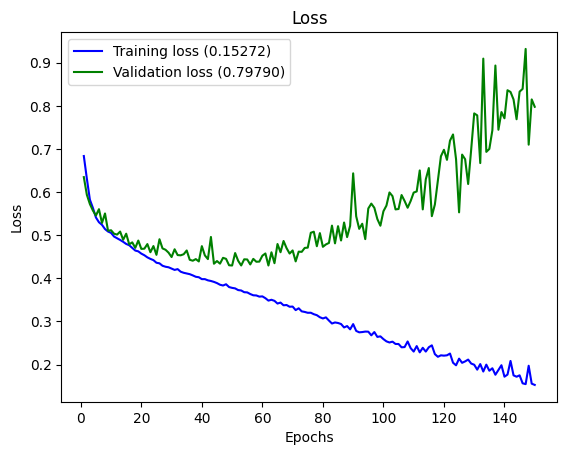

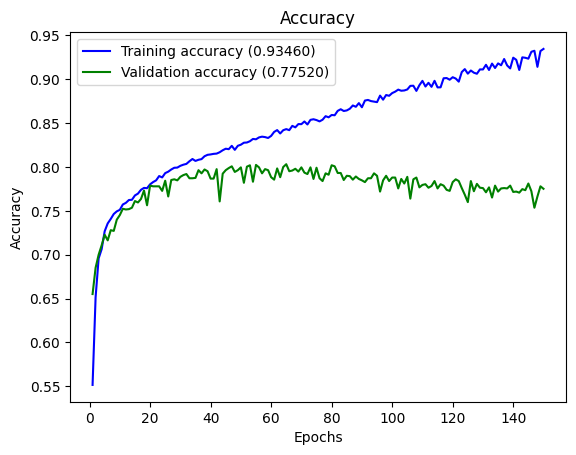

In [234]:
plot_history(accuracy_history, loss_history, val_accuracy_history, val_loss_history)